![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import joblib

import os
os.chdir('..')

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


## Preprocesamiento de datos (10 puntos)

Los datos de entrenamiento se dividen en datos de entrenamiento y validación. Si decidieron preprocesar los datos (estandarizar, normalizar, imputar valores, etc), estos son correctamente preprocesados al ajustar sobre los datos de entrenamiento (.fit_transform()) y al transformar los datos del set de validación (.transform()). (10 puntos)

Se mira la correlacion del precio con el estado y se ve que este no lo afecta de forma muy substancial, por lo que se decide eliminar el estado de los datos

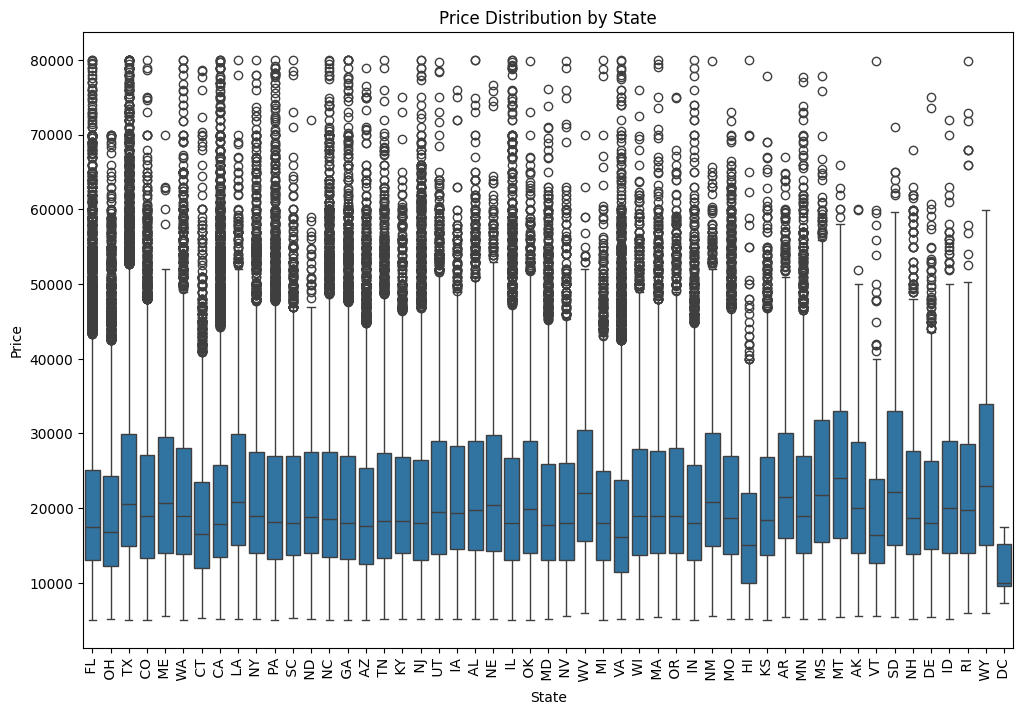

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(x='State', y='Price', data=dataTraining)
plt.xticks(rotation=90)
plt.title('Price Distribution by State')
plt.ylabel('Price')
plt.xlabel('State')
plt.show()

In [7]:
# Preprocesamiento de datos
# Visualización dataset
# Preprocesamiento de datos
dataTraining = dataTraining.drop(['Make'], axis=1)
dataTesting = dataTesting.drop(['Make'], axis=1)

# Visualización dataset
dataTraining.head()
categorical_columns = ['Model', 'State'] 
for col in categorical_columns:
    dataTraining[col] = dataTraining[col].astype('category')
    dataTesting[col] = dataTesting[col].astype('category')

# Visualización dataset
dataTraining.head()

,Price,Year,Mileage,State,Model
0,34995,2017,9913,FL,Wrangler
1,37895,2015,20578,OH,Tahoe4WD
2,18430,2012,83716,TX,X5AWD
3,24681,2014,28729,OH,SRXLuxury
4,26998,2013,64032,CO,Wrangler


In [8]:

# Visualización dataset
dataTesting.head()

,Year,Mileage,State,Model
ID,,,,
0,2014,31909,MD,MuranoAWD
1,2017,5362,FL,Wrangler
2,2014,50300,OH,FlexLimited
3,2004,132160,WA,5
4,2015,25226,MA,Grand


In [9]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split, GridSearchCV
X = dataTraining.drop(['Price'], axis=1)
y = dataTraining['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<Axes: xlabel='Year', ylabel='Mileage'>

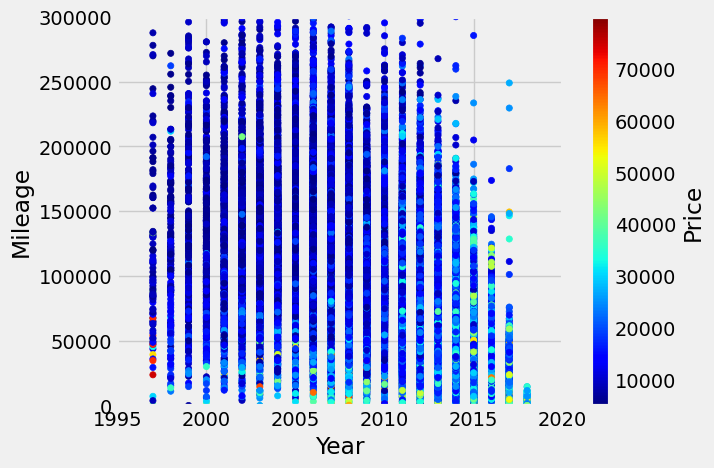

In [10]:
# Visualización de la información
# Gráfica del salario, años y hits

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
dataTraining.plot(kind='scatter', x='Year', y='Mileage', c='Price', colormap='jet', xlim=(1995, 2020), ylim=(0, 300000))

## Calibración del modelo (15 puntos)

Se calibran los parámetros que se consideren pertinentes del modelo de clasificación seleccionado. (5 puntos)

Se justifica el método seleccionado de calibración. (5 puntos)

Se analizan los valores calibrados de cada parámetro y se explica cómo afectan el modelo. (5 puntos)

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

modelo = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)

parametros = {
    'learning_rate': [0.1],
    'n_estimators': [300],
    'max_depth': [6],
    'colsample_bytree': [1],
    'subsample': [1],
    'reg_lambda': [2]   
}

grid_search_xgb = GridSearchCV(estimator=modelo, param_grid=parametros, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

print("Mejores parametros:", grid_search_xgb.best_params_)

mejor_modelo = grid_search_xgb.best_estimator_

y = mejor_modelo.predict(X_test)

mse = mean_squared_error(y_test, y)
print("MSE:", mse)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores parametros: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'reg_lambda': 2, 'subsample': 1}
MSE: 12134125.841430696


In [12]:
# Exportar modelo a archivo binario .pkl
import joblib
joblib.dump(grid_search_xgb, 'precio_vehiculo.pkl', compress=3)

['precio_vehiculo.pkl']

In [13]:
# Importación librerías
from flask import Flask
from flask_restx import Api, Resource, fields

In [14]:
# Definición aplicación Flask
app = Flask(__name__)

# Definición API Flask
api = Api(
    app, 
    version='1.0', 
    title='API Prediccion Precio Vehiculos',
    description='API Prediccion Precio Vehiculos')

ns = api.namespace('Predicción', 
     description='Precio Vehiculos')

# Definición argumentos o parámetros de la API
parser = api.parser()
parser.add_argument(
    'Year', type=int, required=True, help='Year of the car', location='args')
parser.add_argument(
    'Mileage', type=int, required=True, help='Mileage of the car', location='args')
parser.add_argument(
    'Model', type=str, required=True, help='Model of the car', location='args')
parser.add_argument(
    'State', type=str, required=True, help='State of the car', location='args')

resource_fields = api.model('Resource', {
    'Price': fields.Float,
})

In [15]:
# Definición de la clase para disponibilización
@ns.route('/')
class PricePrediction(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "Price": mejor_modelo.predict(args['Year', 'Mileage', 'Model', 'State'])
        }, 200

In [16]:
# Ejecución de la aplicación que disponibiliza el modelo de manera local en el puerto 5000
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.11.3:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Apr/2024 22:49:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Apr/2024 22:49:25] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Apr/2024 22:49:25] "GET /swaggerui/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Apr/2024 22:49:25] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Apr/2024 22:49:25] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Apr/2024 22:49:25] "GET /swagger.json HTTP/1.1" 200 -


In [ ]:
#y1 = pd.DataFrame(y)
#y1

,0
0,12943.853516
1,23847.769531
2,14841.042969
3,8402.610352
4,45366.300781
...,...
131995,31810.787109
131996,34583.113281
131997,21382.923828
131998,15904.841797


In [ ]:
#y1.insert(0, 'ID', range(0, len(y1)))
#y1

,ID,0
0,0,12943.853516
1,1,23847.769531
2,2,14841.042969
3,3,8402.610352
4,4,45366.300781
...,...,...
131995,131995,31810.787109
131996,131996,34583.113281
131997,131997,21382.923828
131998,131998,15904.841797


In [ ]:
#y1.columns.values[1] = 'Price'
#y1

,ID,Price
0,0,12943.853516
1,1,23847.769531
2,2,14841.042969
3,3,8402.610352
4,4,45366.300781
...,...,...
131995,131995,31810.787109
131996,131996,34583.113281
131997,131997,21382.923828
131998,131998,15904.841797


In [ ]:
#y1.to_csv('test_submissionp2.csv', index=False)